<a href="https://colab.research.google.com/github/Sudiptermux/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/Oil_Spill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

IMAGE_DIR = "/content/drive/MyDrive/images"
MASK_DIR = "/content/drive/MyDrive/masks"
FILTERED_IMAGE_DIR = "/content/drive/MyDrive/filtered_images"  # Define filtered images path here

print("Total Images:", len(os.listdir(IMAGE_DIR)))
print("Total Masks:", len(os.listdir(MASK_DIR)))

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

print("First 5 Images:", image_files[:5])
print("First 5 Masks:", mask_files[:5])



Total Images: 811
Total Masks: 811
First 5 Images: ['Oil (1).jpg', 'Oil (10).jpg', 'Oil (100).jpg', 'Oil (1000).jpg', 'Oil (1001).jpg']
First 5 Masks: ['Oil (1).png', 'Oil (10).png', 'Oil (100).png', 'Oil (1000).png', 'Oil (1001).png']


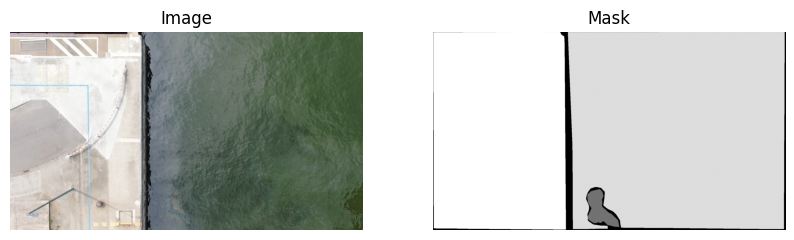

In [ ]:
# Pick one sample to visualize
idx = 0
image_path = os.path.join(IMAGE_DIR, image_files[idx])
mask_path = os.path.join(MASK_DIR, mask_files[idx])

# Load
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
mask = cv2.imread(mask_path, 0)  # Load mask in grayscale

# Plot
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

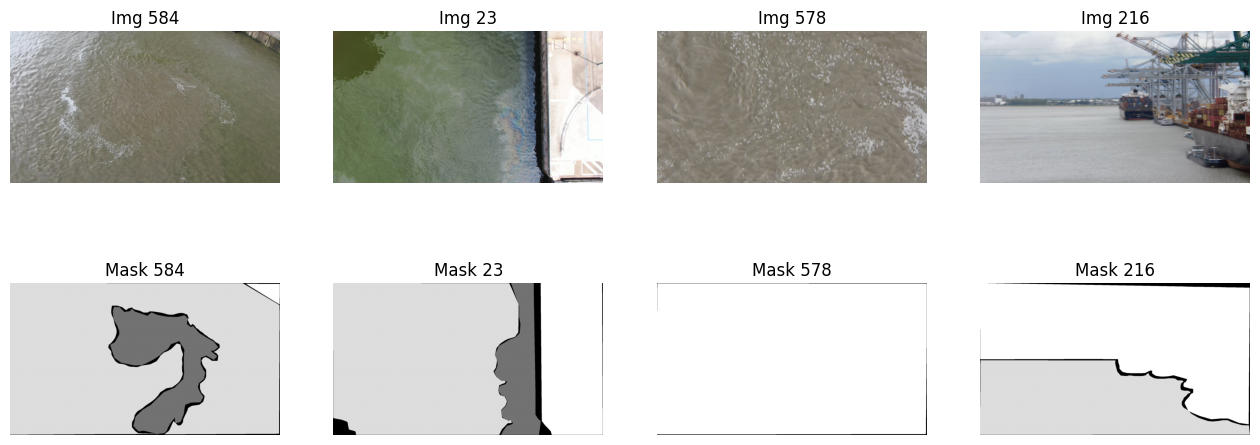

In [ ]:
import random

# Number of samples to visualize
n = 4

# Randomly select n indices
indices = random.sample(range(len(image_files)), n)
plt.figure(figsize=(4 * n, 6))

for i, idx in enumerate(indices):
    img_path = os.path.join(IMAGE_DIR, image_files[idx])
    mask_path = os.path.join(MASK_DIR, mask_files[idx])

    # Load image in RGB
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # Load mask in grayscale
    mask = cv2.imread(mask_path, 0)

    # Show image
    plt.subplot(2, n, i + 1)
    plt.imshow(img)
    plt.title(f"Img {idx}")
    plt.axis("off")

    # Show mask
    plt.subplot(2, n, n + i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.show()


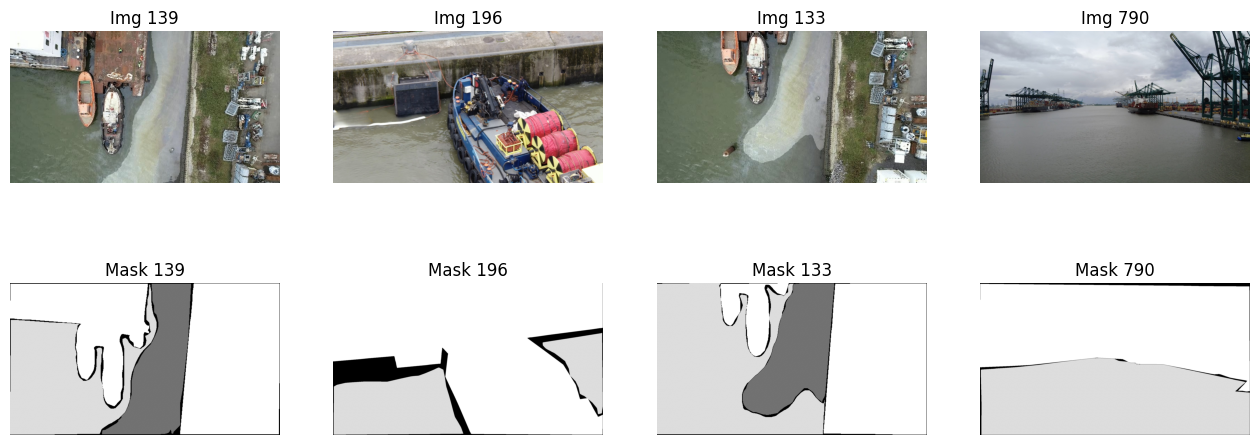

In [ ]:
import random

# Number of samples to visualize
n = 4

# Randomly select n indices
indices = random.sample(range(len(image_files)), n)
plt.figure(figsize=(4 * n, 6))

for i, idx in enumerate(indices):
    img_path = os.path.join(IMAGE_DIR, image_files[idx])
    mask_path = os.path.join(MASK_DIR, mask_files[idx])

    # Load image in RGB
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # Load mask in grayscale
    mask = cv2.imread(mask_path, 0)

    # Normalize image and mask to [0,1]
    img = img.astype('float32') / 255.0
    mask = mask.astype('float32') / 255.0

    # Show normalized image
    plt.subplot(2, n, i + 1)
    plt.imshow(img)
    plt.title(f"Img {idx}")
    plt.axis("off")

    # Show normalized mask
    plt.subplot(2, n, n + i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.show()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-695619451.py:12: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
/tmp/ipython-input-695619451.py:16: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),


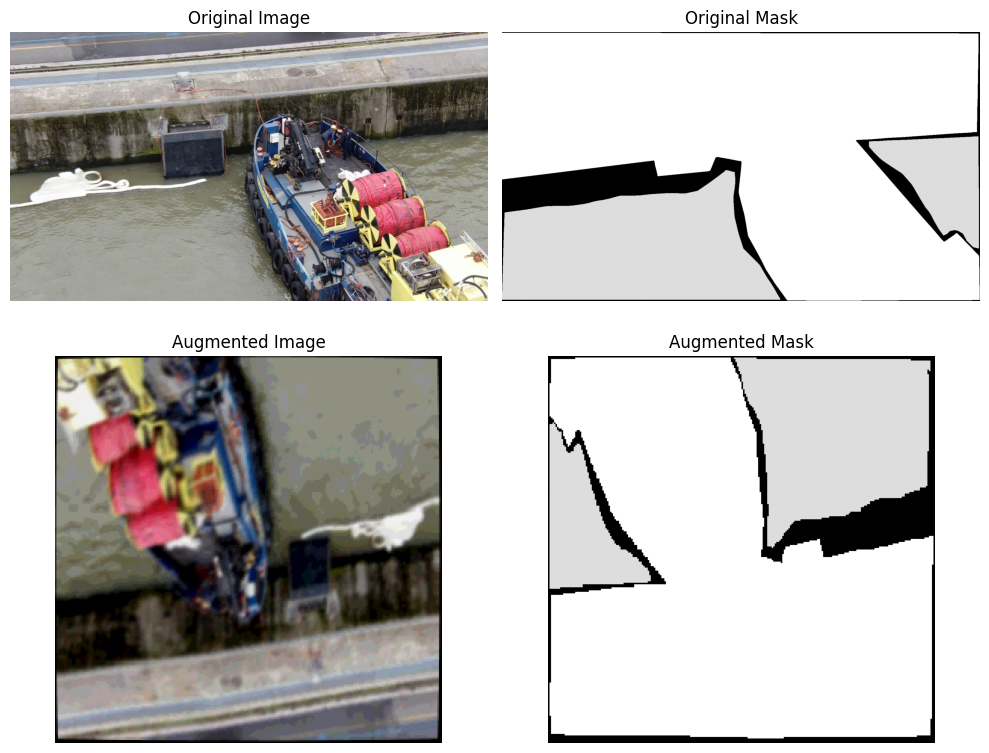

In [ ]:
import albumentations as A

# Define augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    A.ChannelShuffle(p=0.3),
    A.Posterize(num_bits=4, p=0.3),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])


# Apply augmentation to all image-mask pairs
augmented_images = []
augmented_masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)

    augmented = transform(image=image, mask=mask)
    augmented_images.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

# Visualize augmentation for one random pair
idx = random.randint(0, len(augmented_images)-1)

plt.figure(figsize=(10, 8))

# Original
orig_img_path = os.path.join(IMAGE_DIR, image_files[idx])
orig_mask_path = os.path.join(MASK_DIR, mask_files[idx])
orig_img = cv2.cvtColor(cv2.imread(orig_img_path), cv2.COLOR_BGR2RGB)
orig_mask = cv2.imread(orig_mask_path, 0)

plt.subplot(2, 2, 1)
plt.imshow(orig_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(orig_mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

# Augmented
plt.subplot(2, 2, 3)
plt.imshow(augmented_images[idx])
plt.title('Augmented Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(augmented_masks[idx], cmap='gray')
plt.title('Augmented Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


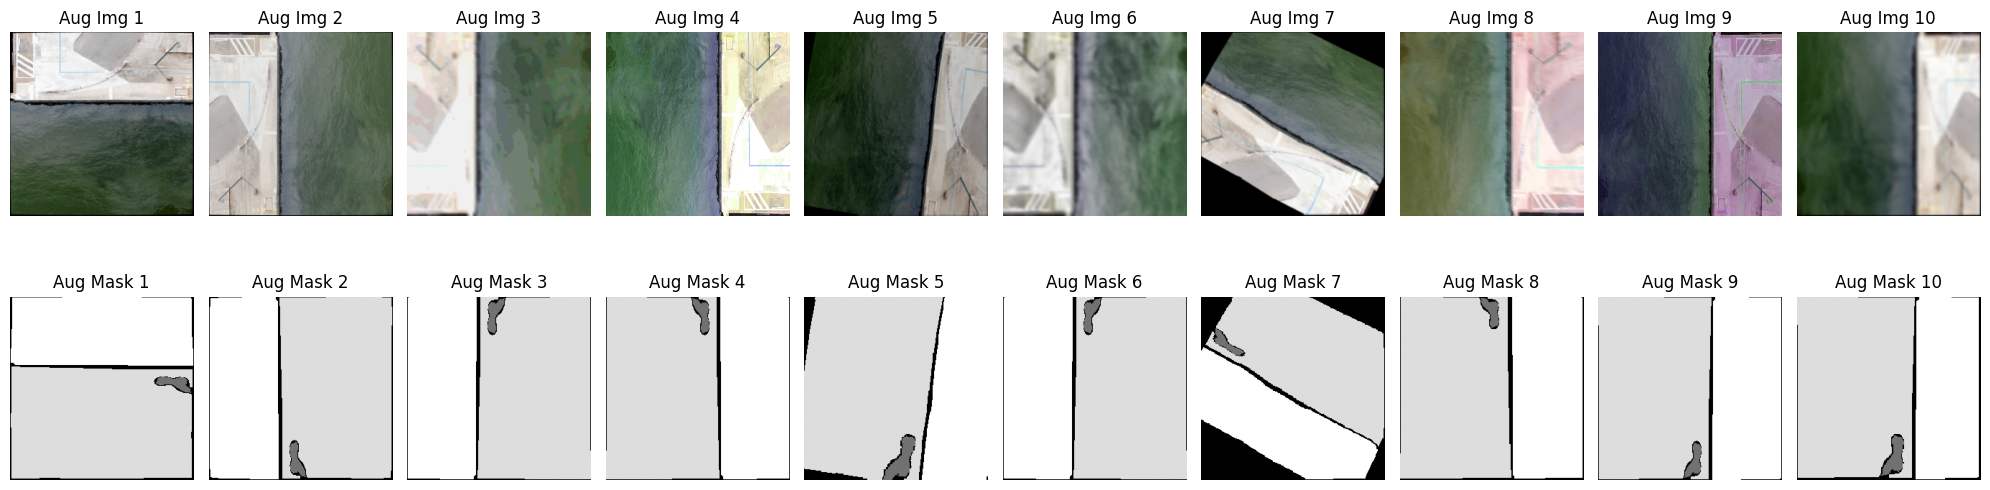

In [ ]:
import matplotlib.pyplot as plt

# Number of augmentations to show
num_augs = 10

# Load one image and mask (e.g., index 0)
idx = 0
img_path = os.path.join(IMAGE_DIR, image_files[idx])
mask_path = os.path.join(MASK_DIR, mask_files[idx])

image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, 0)

plt.figure(figsize=(20, 6))

for i in range(num_augs):
    augmented = transform(image=image, mask=mask)  # Apply augmentation
    aug_img = augmented['image']
    aug_mask = augmented['mask']

    # Plot augmented image in first row
    plt.subplot(2, num_augs, i + 1)
    plt.imshow(aug_img)
    plt.title(f'Aug Img {i+1}')
    plt.axis('off')

    # Plot augmented mask in second row
    plt.subplot(2, num_augs, num_augs + i + 1)
    plt.imshow(aug_mask, cmap='gray')
    plt.title(f'Aug Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


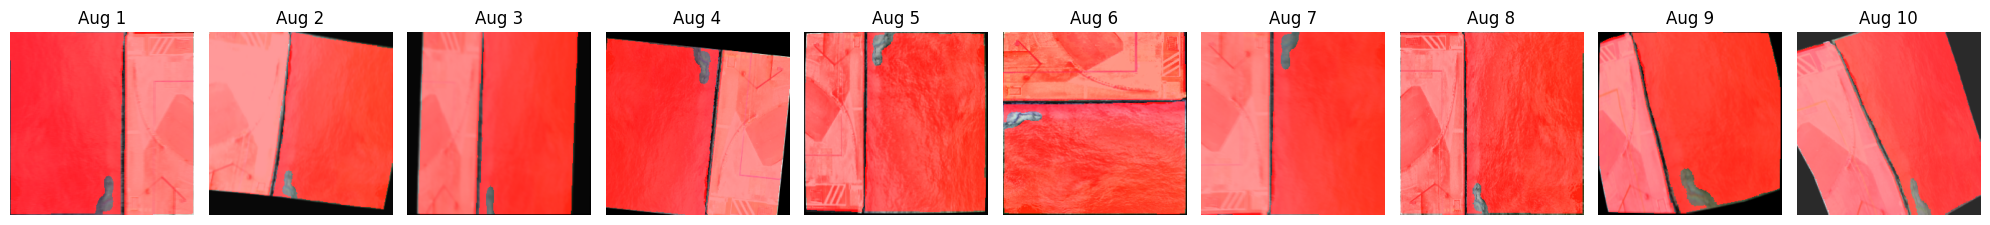

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Number of augmentations to show
num_augs = 10

# Pick one image and mask (e.g., index 0)
idx = 0
img_path = os.path.join(IMAGE_DIR, image_files[idx])
mask_path = os.path.join(MASK_DIR, mask_files[idx])

image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, 0)

# Convert mask to binary
mask = (mask > 127).astype(np.uint8)

# Function to overlay mask on image
def overlay_mask(img, msk, color=(255, 0, 0), alpha=0.4):
    overlay = img.copy()
    overlay[msk == 1] = color
    return cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)

plt.figure(figsize=(20, 4))

for i in range(num_augs):
    augmented = transform(image=image, mask=mask)  # Apply augmentation
    aug_img, aug_mask = augmented['image'], augmented['mask']

    # Overlay mask
    blended = overlay_mask(aug_img, aug_mask)

    plt.subplot(1, num_augs, i + 1)
    plt.imshow(blended)
    plt.title(f'Aug {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import os

# Lee Filter Definition
def lee_filter(img, size=7):
    img = img.astype(np.float32)
    kernel = np.ones((size, size), dtype=np.float32) / (size * size)
    local_mean = cv2.filter2D(img, -1, kernel)
    local_var = cv2.filter2D(img**2, -1, kernel) - local_mean**2
    overall_var = np.var(img)
    img_out = local_mean + (local_var / (local_var + overall_var)) * (img - local_mean)
    return img_out.astype(np.uint8)

# Apply filter to all images and save filtered versions
filtered_dir = "/content/drive/MyDrive/filtered_images"  # Change as needed
os.makedirs(filtered_dir, exist_ok=True)

for img_file in os.listdir(IMAGE_DIR):
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    filtered_img = lee_filter(img)
    save_path = os.path.join(filtered_dir, img_file)
    cv2.imwrite(save_path, filtered_img)
    print(f"Filtered and saved: {save_path}")


Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1004).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (10).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1000).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1003).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (100).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1002).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1001).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1020).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1015).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (1065).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (101).jpg
Filtered and saved: /content/drive/MyDrive/filtered_images/Oil (103).jpg
Filtered and saved: /content/drive/MyDrive/fil

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
import cv2
import numpy as np
import os

# --- FINAL CORRECTED DATASET CLASS ---
class OilSpillDataset(Dataset):
    """
    Custom PyTorch Dataset for loading oil spill images and masks.
    This version correctly binarizes the masks for training.
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Binarize the mask: any pixel value > 127 becomes 1, otherwise it's 0.
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return image, mask

# --- CREATE AND SPLIT THE DATASET ---
# This assumes your FILTERED_IMAGE_DIR, MASK_DIR, and transform variables are already defined
dataset = OilSpillDataset(FILTERED_IMAGE_DIR, MASK_DIR, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Dataset created and split successfully.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Dataset created and split successfully.
Train dataset size: 648
Validation dataset size: 163


/tmp/ipython-input-966787511.py:42: RuntimeWarning: invalid value encountered in sqrt
  spill_std = np.sqrt(spill_var)
/tmp/ipython-input-966787511.py:46: RuntimeWarning: invalid value encountered in sqrt
  nonspill_std = np.sqrt(nonspill_var)


Spill region - Mean: 140.87, Std Dev: nan
Non-spill region - Mean: 102.63, Std Dev: nan


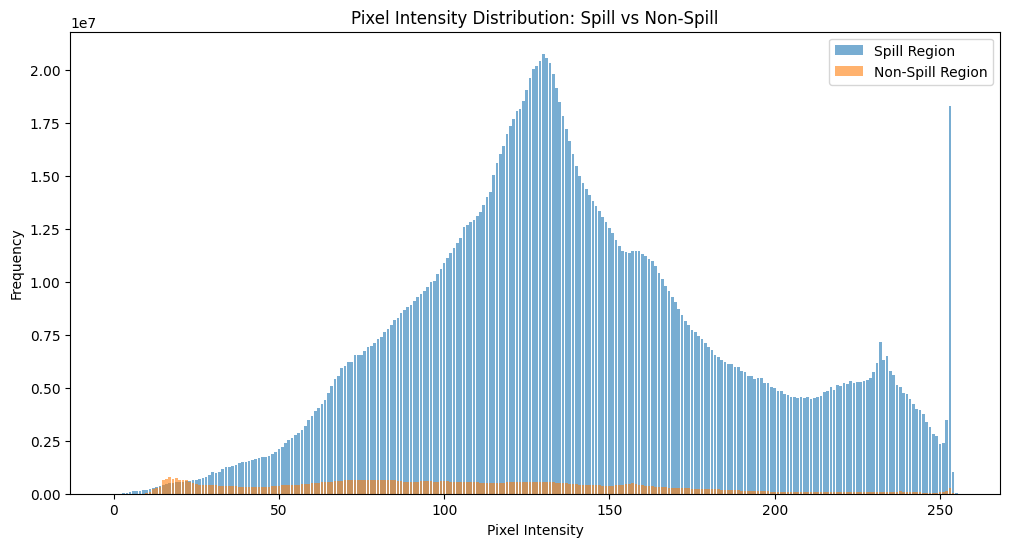

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

spill_sum = 0
spill_sum_sq = 0
spill_count = 0

nonspill_sum = 0
nonspill_sum_sq = 0
nonspill_count = 0

# For histogram
spill_hist = np.zeros(256)
nonspill_hist = np.zeros(256)

for img_file, mask_file in zip(sorted(os.listdir(FILTERED_IMAGE_DIR)), sorted(os.listdir(MASK_DIR))):
    img_path = os.path.join(FILTERED_IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Spill pixels
    spill_pixels = img[mask > 0]
    spill_sum += np.sum(spill_pixels)
    spill_sum_sq += np.sum(spill_pixels**2)
    spill_count += spill_pixels.size
    spill_hist += np.bincount(spill_pixels, minlength=256)

    # Non-spill pixels
    nonspill_pixels = img[mask == 0]
    nonspill_sum += np.sum(nonspill_pixels)
    nonspill_sum_sq += np.sum(nonspill_pixels**2)
    nonspill_count += nonspill_pixels.size
    nonspill_hist += np.bincount(nonspill_pixels, minlength=256)

# Calculate means and stddevs
spill_mean = spill_sum / spill_count
spill_var = (spill_sum_sq / spill_count) - (spill_mean ** 2)
spill_std = np.sqrt(spill_var)

nonspill_mean = nonspill_sum / nonspill_count
nonspill_var = (nonspill_sum_sq / nonspill_count) - (nonspill_mean ** 2)
nonspill_std = np.sqrt(nonspill_var)

print(f"Spill region - Mean: {spill_mean:.2f}, Std Dev: {spill_std:.2f}")
print(f"Non-spill region - Mean: {nonspill_mean:.2f}, Std Dev: {nonspill_std:.2f}")

# Plot histograms
plt.figure(figsize=(12, 6))
plt.bar(range(256), spill_hist, alpha=0.6, label='Spill Region')
plt.bar(range(256), nonspill_hist, alpha=0.6, label='Non-Spill Region')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution: Spill vs Non-Spill')
plt.legend()
plt.show()


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.6 MB/s eta 0:00:00


In [ ]:
# Install the required library first
!pip install -q segmentation-models-pytorch

import segmentation_models_pytorch as smp

# This new code replaces your entire previous UNET class definition.
# It creates a U-Net with a powerful ResNet34 encoder pre-trained on ImageNet,
# which is the most effective way to improve your model's accuracy.
model = smp.Unet(
    encoder_name="resnet34",        # Use the popular and effective ResNet34 backbone
    encoder_weights="imagenet",     # Load weights pre-trained on ImageNet for a head start
    in_channels=3,                  # Your input images have 3 channels
    classes=1,                      # Your output is a single mask
)

print("U-Net with pre-trained ResNet34 encoder created successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

U-Net with pre-trained ResNet34 encoder created successfully.


In [ ]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCEWithLogitsLoss()

    def dice_loss_func(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

    def forward(self, inputs, targets):
        if targets.dim() == 3:
             targets_bce = targets.float().unsqueeze(1)
        else:
             targets_bce = targets.float()

        bce = self.bce_loss(inputs, targets_bce)
        dice = self.dice_loss_func(inputs, targets)
        total_loss = self.bce_weight * bce + (1 - self.bce_weight) * dice
        return total_loss

print("DiceBCELoss function defined.")

DiceBCELoss function defined.


In [ ]:
# MAIN TRAINING SCRIPT WITH SCHEDULER
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics import JaccardIndex

# -- Final Hyperparameters & Setup --
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 50  # Increased epochs for the better model
NUM_WORKERS = 2

# -- Initialization --
# The model is now defined in Cell 1, so we just move it to the device
model.to(DEVICE)
loss_fn = DiceBCELoss() # Your loss function from Cell 2 is still used
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
jaccard = JaccardIndex(task="binary").to(DEVICE)

# --- ADDED: Learning Rate Scheduler ---
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Helper Functions ---
def train_one_epoch(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, leave=True)
    model.train()
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

def check_accuracy(loader, model, device="cuda"):
    iou_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            y_with_channel = y.unsqueeze(1)
            iou_score += jaccard(preds_binary, y_with_channel.int())

    avg_iou = iou_score/len(loader)
    print(f"Validation IoU: {avg_iou:.4f}")
    return avg_iou

# --- Main Training Loop with Early Stopping ---
print(f"--- Starting Training on {DEVICE.upper()} ---")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

best_val_iou = -1.0
epochs_no_improve = 0
patience = 7 # Increased patience for a more powerful model

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    train_one_epoch(train_loader, model, optimizer, loss_fn)
    val_iou = check_accuracy(val_loader, model, device=DEVICE)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        epochs_no_improve = 0
        checkpoint = {"state_dict": model.state_dict()}
        torch.save(checkpoint, "/content/drive/MyDrive/best_model_oil_spill_v2.pth.tar")
        print(f"✓ Model Saved! New best IoU: {best_val_iou:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # --- ADDED: Update the scheduler ---
    scheduler.step()

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

--- Starting Training on CUDA ---

Epoch [1/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.438]


Validation IoU: 0.6522
✓ Model Saved! New best IoU: 0.6522

Epoch [2/50]


100%|██████████| 41/41 [00:37<00:00,  1.09it/s, loss=0.583]


Validation IoU: 0.7570
✓ Model Saved! New best IoU: 0.7570

Epoch [3/50]


100%|██████████| 41/41 [00:38<00:00,  1.07it/s, loss=0.394]


Validation IoU: 0.7729
✓ Model Saved! New best IoU: 0.7729

Epoch [4/50]


100%|██████████| 41/41 [00:39<00:00,  1.05it/s, loss=0.32]


Validation IoU: 0.8002
✓ Model Saved! New best IoU: 0.8002

Epoch [5/50]


100%|██████████| 41/41 [00:38<00:00,  1.05it/s, loss=0.36]


Validation IoU: 0.7958
No improvement for 1 epoch(s).

Epoch [6/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.222]


Validation IoU: 0.7982
No improvement for 2 epoch(s).

Epoch [7/50]


100%|██████████| 41/41 [00:35<00:00,  1.16it/s, loss=0.241]


Validation IoU: 0.8390
✓ Model Saved! New best IoU: 0.8390

Epoch [8/50]


100%|██████████| 41/41 [00:39<00:00,  1.05it/s, loss=0.265]


Validation IoU: 0.8550
✓ Model Saved! New best IoU: 0.8550

Epoch [9/50]


100%|██████████| 41/41 [00:38<00:00,  1.06it/s, loss=0.193]


Validation IoU: 0.8276
No improvement for 1 epoch(s).

Epoch [10/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.291]


Validation IoU: 0.8496
No improvement for 2 epoch(s).

Epoch [11/50]


100%|██████████| 41/41 [00:35<00:00,  1.17it/s, loss=0.225]


Validation IoU: 0.8761
✓ Model Saved! New best IoU: 0.8761

Epoch [12/50]


100%|██████████| 41/41 [00:38<00:00,  1.06it/s, loss=0.385]


Validation IoU: 0.8749
No improvement for 1 epoch(s).

Epoch [13/50]


100%|██████████| 41/41 [00:36<00:00,  1.14it/s, loss=0.239]


Validation IoU: 0.8387
No improvement for 2 epoch(s).

Epoch [14/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.233]


Validation IoU: 0.8698
No improvement for 3 epoch(s).

Epoch [15/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.15]


Validation IoU: 0.8600
No improvement for 4 epoch(s).

Epoch [16/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.164]


Validation IoU: 0.8743
No improvement for 5 epoch(s).

Epoch [17/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.166]


Validation IoU: 0.8754
No improvement for 6 epoch(s).

Epoch [18/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.275]


Validation IoU: 0.8878
✓ Model Saved! New best IoU: 0.8878

Epoch [19/50]


100%|██████████| 41/41 [00:37<00:00,  1.08it/s, loss=0.288]


Validation IoU: 0.8889
✓ Model Saved! New best IoU: 0.8889

Epoch [20/50]


100%|██████████| 41/41 [00:38<00:00,  1.05it/s, loss=0.151]


Validation IoU: 0.8678
No improvement for 1 epoch(s).

Epoch [21/50]


100%|██████████| 41/41 [00:35<00:00,  1.16it/s, loss=0.334]


Validation IoU: 0.8698
No improvement for 2 epoch(s).

Epoch [22/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.238]


Validation IoU: 0.9053
✓ Model Saved! New best IoU: 0.9053

Epoch [23/50]


100%|██████████| 41/41 [00:38<00:00,  1.06it/s, loss=0.155]


Validation IoU: 0.8903
No improvement for 1 epoch(s).

Epoch [24/50]


100%|██████████| 41/41 [00:36<00:00,  1.14it/s, loss=0.177]


Validation IoU: 0.9022
No improvement for 2 epoch(s).

Epoch [25/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.144]


Validation IoU: 0.8944
No improvement for 3 epoch(s).

Epoch [26/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.0831]


Validation IoU: 0.9080
✓ Model Saved! New best IoU: 0.9080

Epoch [27/50]


100%|██████████| 41/41 [00:38<00:00,  1.05it/s, loss=0.143]


Validation IoU: 0.9083
✓ Model Saved! New best IoU: 0.9083

Epoch [28/50]


100%|██████████| 41/41 [00:38<00:00,  1.06it/s, loss=0.155]


Validation IoU: 0.9062
No improvement for 1 epoch(s).

Epoch [29/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.116]


Validation IoU: 0.9054
No improvement for 2 epoch(s).

Epoch [30/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.203]


Validation IoU: 0.9090
✓ Model Saved! New best IoU: 0.9090

Epoch [31/50]


100%|██████████| 41/41 [00:37<00:00,  1.09it/s, loss=0.213]


Validation IoU: 0.9064
No improvement for 1 epoch(s).

Epoch [32/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.133]


Validation IoU: 0.9051
No improvement for 2 epoch(s).

Epoch [33/50]


100%|██████████| 41/41 [00:36<00:00,  1.13it/s, loss=0.176]


Validation IoU: 0.9164
✓ Model Saved! New best IoU: 0.9164

Epoch [34/50]


100%|██████████| 41/41 [00:39<00:00,  1.04it/s, loss=0.141]


Validation IoU: 0.9027
No improvement for 1 epoch(s).

Epoch [35/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.188]


Validation IoU: 0.9140
No improvement for 2 epoch(s).

Epoch [36/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.105]


Validation IoU: 0.9110
No improvement for 3 epoch(s).

Epoch [37/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.084]


Validation IoU: 0.9135
No improvement for 4 epoch(s).

Epoch [38/50]


100%|██████████| 41/41 [00:35<00:00,  1.14it/s, loss=0.169]


Validation IoU: 0.9161
No improvement for 5 epoch(s).

Epoch [39/50]


100%|██████████| 41/41 [00:37<00:00,  1.10it/s, loss=0.0764]


Validation IoU: 0.9203
✓ Model Saved! New best IoU: 0.9203

Epoch [40/50]


100%|██████████| 41/41 [00:39<00:00,  1.03it/s, loss=0.249]


Validation IoU: 0.9189
No improvement for 1 epoch(s).

Epoch [41/50]


100%|██████████| 41/41 [00:37<00:00,  1.11it/s, loss=0.138]


Validation IoU: 0.9164
No improvement for 2 epoch(s).

Epoch [42/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.311]


Validation IoU: 0.9198
No improvement for 3 epoch(s).

Epoch [43/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.27]


Validation IoU: 0.9190
No improvement for 4 epoch(s).

Epoch [44/50]


100%|██████████| 41/41 [00:37<00:00,  1.10it/s, loss=0.162]


Validation IoU: 0.9183
No improvement for 5 epoch(s).

Epoch [45/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.0906]


Validation IoU: 0.9157
No improvement for 6 epoch(s).

Epoch [46/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.12]


Validation IoU: 0.9193
No improvement for 7 epoch(s).

Early stopping triggered after 46 epochs.


In [ ]:
import torch
import segmentation_models_pytorch as smp

# --- 1. LOAD YOUR NEW MODEL ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the NEW model architecture
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

# Load the weights for the NEW model
MODEL_PATH = "/content/drive/MyDrive/best_model_oil_spill_v2.pth.tar"
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

print(f"✓ Best model loaded successfully from: {MODEL_PATH}")

✓ Best model loaded successfully from: /content/drive/MyDrive/best_model_oil_spill_v2.pth.tar


In [ ]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# --- Define Manual Metric Functions ---
def calculate_dice_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice

def calculate_iou_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    total = (preds + targets).sum()
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# --- Evaluate on the Entire Validation Set ---
print("\nCalculating final scores on the validation dataset...")

total_iou = 0
total_dice = 0
num_batches = 0

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        preds = torch.sigmoid(model(x))
        preds_binary = (preds > 0.5).float()

        total_iou += calculate_iou_score(preds_binary, y).item()
        total_dice += calculate_dice_score(preds_binary, y).item()
        num_batches += 1

# Calculate the average scores across all batches
avg_iou = total_iou / num_batches
avg_dice = total_dice / num_batches

print("\n--- Final Model Performance ---")
print(f"Intersection over Union (IoU): {avg_iou*100:.2f}%")
print(f"Dice Score: {avg_dice*100:.2f}%")


Calculating final scores on the validation dataset...

--- Final Model Performance ---
Intersection over Union (IoU): 91.01%
Dice Score: 95.28%



Generating predictions on validation images 


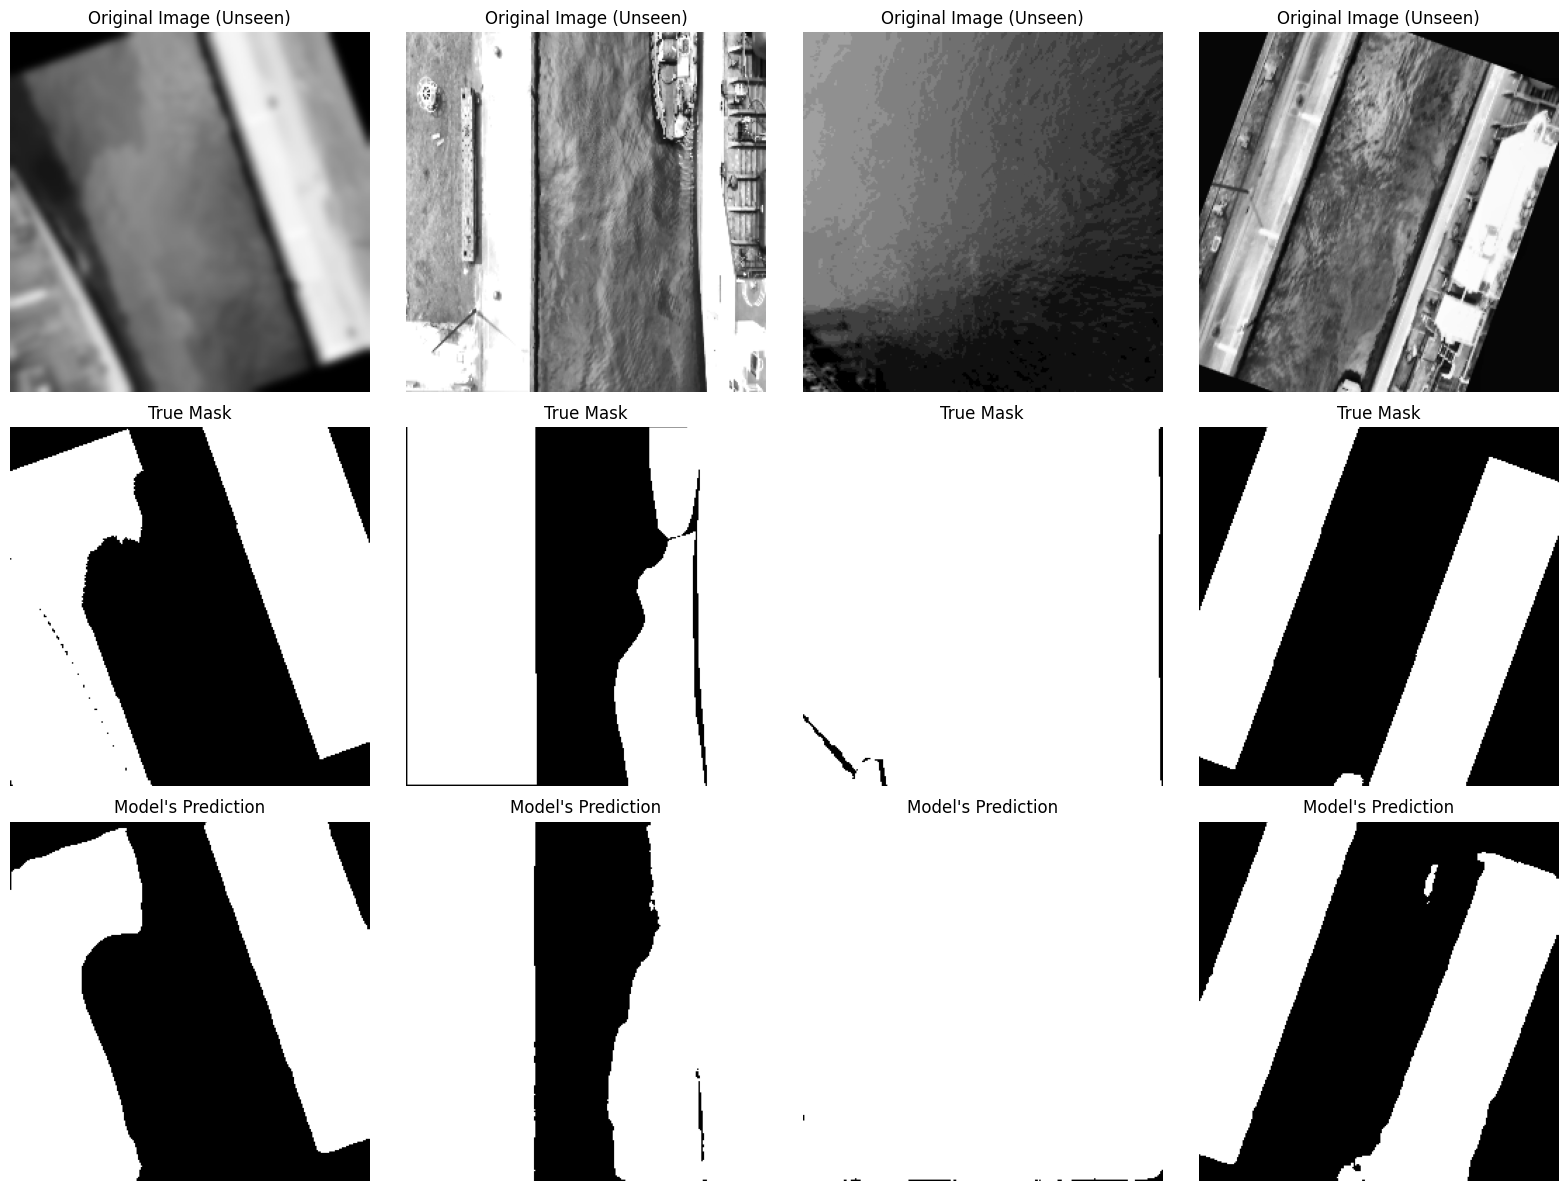

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("\nGenerating predictions on validation images ")
images, masks = next(iter(val_loader))
images = images.to(DEVICE)

plt.figure(figsize=(16, 12))
with torch.no_grad():
    # Get model's prediction
    preds_binary = (torch.sigmoid(model(images)) > 0.5).float()

    # Move all tensors to the CPU for plotting
    images_cpu, masks_cpu, preds_binary_cpu = images.cpu(), masks.cpu(), preds_binary.cpu()

    # Loop through the first 4 images in the batch to plot them
    for i in range(min(len(images), 4)):
        # Plot the original image
        plt.subplot(3, 4, i + 1)
        plt.imshow(np.transpose(images_cpu[i].numpy(), (1, 2, 0)))
        plt.title("Original Image (Unseen)")
        plt.axis("off")

        # Plot the true, correct mask
        plt.subplot(3, 4, i + 5)
        plt.imshow(masks_cpu[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        # Plot the model's predicted mask
        plt.subplot(3, 4, i + 9)
        plt.imshow(preds_binary_cpu[i].squeeze(), cmap='gray')
        plt.title("Model's Prediction")
        plt.axis("off")

plt.tight_layout()
plt.show()